In [1]:
import numpy as np
import pandas as pd
import subprocess as sp
import os
import shutil
import matplotlib.pyplot as plt

import scipy.interpolate
import scipy

import MDAnalysis as mda

from math import exp, log
import scipy.stats

import glob

In [ ]:
base_dir = '/home/dom/Projects/Playground/machine_learning/deep-lda/bCB_g1'

/home/dom/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


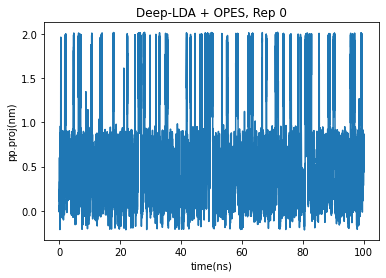

/home/dom/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


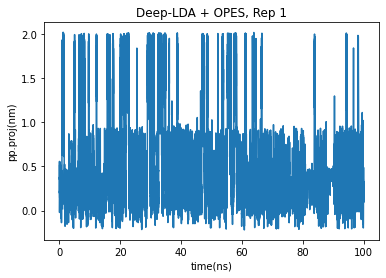

/home/dom/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


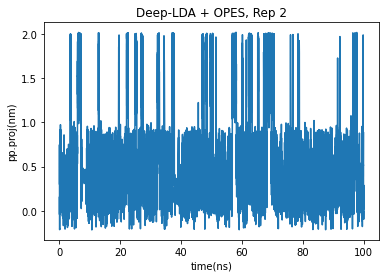

/home/dom/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


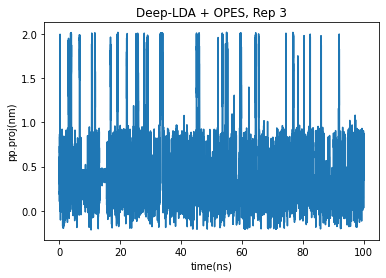

/home/dom/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


/home/dom/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


/home/dom/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


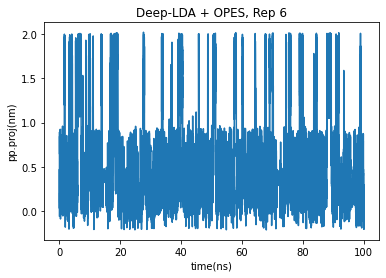

/home/dom/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


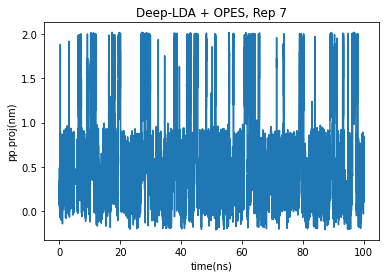

/home/dom/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


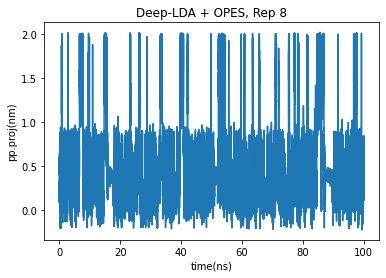

/home/dom/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


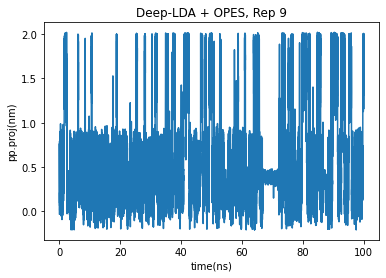

In [11]:
##########################
## plotting CVs vs time ##
# for guest-host systems #
##########################

for i in range(0,10):
    # plot the gaussians over time
    df = pd.read_csv(f'{base_dir}/3_enhanced_sampling/opes_{i}_run/COLVAR', delim_whitespace=True).iloc[1:,:-2]

    # df.columns = ['time','pp.proj','pp.ext','sigma_pp.proj','sigma_pp.ext','height','biasf']
    df.columns = ['time', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9', 'd10', 'pp.proj',\
                  'pp.ext', 's_cent', 'beta_cent', 'wall_width', 'wall_buffer', 'lwall.bias', \
                  'lwall.force2', 'uwall.bias', 'uwall.force2', 'deep.node-0', 'sw', 'wall_center',\
                  'scaling', 'spring', 'wall_bias', 'finalbias.bias', 'finalbias.wall_bias_bias', \
                  'opes.bias', 'opes.rct', 'opes.zed','opes.neff','opes.nker']


    # Drop via logic: similar to SQL 'WHERE' clause
    df = df[df.time != '#!']

    df = df.apply(pd.to_numeric)

    plt.title(f'Deep-LDA + OPES, Rep {i}')
    plt.plot(df.time/1000, df['pp.proj'])
    plt.xlabel('time(ns)')
    plt.ylabel('pp.proj(nm)')
    plt.show()

    # plt.scatter(x = df.time/1000, y = df['sw'], c = 'lightcoral')
    # plt.show()

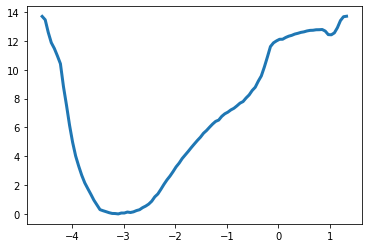

-10.687498312364564


In [28]:
funnel_correction = 1.92

file = f'{base_dir}/3_enhanced_sampling/opes_0_run/fes_1d.dat'

fes_file = [ line.strip().split() for line in open(file).readlines()][5:]

arr = np.array(fes_file)
# arr
plt.plot(arr[:,0].astype(float), arr[:,1].astype(float)/4.184, linewidth = 3)
plt.show()

estimate = -(np.mean(arr[-20:-5,1].astype(float))/4.184 - funnel_correction)

print(estimate)

In [29]:
funnel_correction = 1.92

plt.figure(figsize = (5, 5))
plt.title(f'Deep-LDA + OPES')
plt.xlabel('Time (ns)')
plt.ylabel('Î”G (kcal/mol)')
# plt.axhline(y=-12, c='red')
estimates_lists = []

for i in range(0,10):
    
    # this takes about a minute to run
    
    if not os.path.isfile(f'{base_dir}/3_enhanced_sampling/opes_{i}_run/fes_1d.dat'):
        os.chdir(f'{base_dir}/3_enhanced_sampling/opes_{i}_run')
        sp.call(f'python {base_dir}/4_analysis/scripts/FES_from_Kernels-1D.py --kernels Kernels.data \
            --kt 2.49 --bin 100 --stride 1000 --mintozero --outfile fes_1d.dat',shell=True)
    
    os.chdir(f'{base_dir}/3_enhanced_sampling/opes_{i}_run/fes_running')
    
    ns = []
    estimates = []

    for n in range(1, len(glob.glob('fes_1d.t-*'))+1):

        fes_data = np.loadtxt(f'fes_1d.t-{n*1000}.dat') 

        estimate = -(np.median(fes_data[-20:-5, 1].astype(float))/4.184 - funnel_correction)
        ns.append((n + 1))

        estimates.append(estimate)
    
    print(f'Rep {i}, {estimate:.2f} kcal/mol')
    plt.plot(ns, estimates)
    plt.ylim(-13,-8)
    
    estimates_lists.append(estimates)
        
mean_estimates = []
# in case some sims haven't yet finished, 
# plot the mean up to the shortest sim values
shortest_list = min([ len(item) for item in estimates_lists])

for index in range(shortest_list):
    tmp_list = []
    for l in range(len(estimates_lists)):
        tmp_list.append(estimates_lists[l][index])
    mean_estimates.append(np.mean(tmp_list).round(2))

plt.plot(ns[:len(mean_estimates)], mean_estimates, color = 'black', linewidth = 3,
         label = 'Mean of 10 estimates')
plt.legend()
plt.savefig(f'{base_dir}/deep-lda_opes_gh_vacuum.png', dpi=200, facecolor='w')
plt.show()

Rep 0, -10.75 kcal/mol
Rep 1, -10.64 kcal/mol
Rep 2, -10.95 kcal/mol
Rep 3, -10.90 kcal/mol
Rep 4, -10.79 kcal/mol
Rep 5, -10.65 kcal/mol
Rep 6, -10.67 kcal/mol
Rep 7, -10.51 kcal/mol
Rep 8, -10.85 kcal/mol
Rep 9, -10.69 kcal/mol
